In [1]:
import numpy as np
import os

import ase
import ase.io
import ase.visualize
import ase.geometry.analysis

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon, Circle
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as font_manager

import cycles

In [2]:
xyz_file = "./example/donut-6-b3lyp-opt.xyz"

label = os.path.splitext(os.path.basename(xyz_file))[0]

In [3]:
ase_atoms = ase.io.read(xyz_file)

In [4]:
ase_atoms_no_h = ase.Atoms([a for a in ase_atoms if a.symbol != 'H'])

In [5]:
#ase.visualize.view(ase_atoms_no_h)

In [6]:
# bbox

x_min = np.min(ase_atoms_no_h.positions[:, 0])-1.0
x_max = np.max(ase_atoms_no_h.positions[:, 0])+1.0
y_min = np.min(ase_atoms_no_h.positions[:, 1])-1.0
y_max = np.max(ase_atoms_no_h.positions[:, 1])+1.0

# HOMA parameters based on ref. calcs

In [7]:
benz_xyz = "./reference_geo/benzene_b3lyp_geo/opt.xyz"
butadiene_xyz = "./reference_geo/butadiene_b3lyp_geo/opt.xyz"

ase_benz = ase.io.read(benz_xyz)
ase_buta = ase.io.read(butadiene_xyz)

ana_benz = ase.geometry.analysis.Analysis(ase_benz)
ana_buta = ase.geometry.analysis.Analysis(ase_buta)

In [8]:
benz_bond = ana_benz.get_values(ana_benz.get_bonds('C', 'C'))[0][0]

buta_single = np.min(ana_buta.get_values(ana_buta.get_bonds('C', 'C'))[0])
buta_double = np.max(ana_buta.get_values(ana_buta.get_bonds('C', 'C'))[0])

# Determine alpha, such that "kekule benzene" has HOMA of zero
alpha = 6/(3*(buta_single - benz_bond)**2 + 3*(buta_double - benz_bond)**2)

print("Benzene bond: %.4f" % benz_bond)
print("Alpha: %.4f" % alpha)

Benzene bond: 1.3939
Alpha: 281.2422


# calculate HOMA for each cycle

In [9]:
cycs = cycles.dumb_cycle_detection(ase_atoms_no_h, 8)
centers, normals = cycles.find_cycle_centers_and_normals(ase_atoms_no_h, cycs)

In [10]:
def homa(bond_distances, alpha, r_opt):
    homa = 1.0
    nb = len(bond_distances)
    for dist in bond_distances:
        homa -= alpha/nb * (r_opt - dist)**2
    return homa

In [11]:
def cycle_homa(cycle, ase_atoms, alpha, r_opt):
    bond_distances = []
    for i_at_c in range(len(cycle)):
        at1 = ase_atoms[cycle[i_at_c]]
        at2 = ase_atoms[cycle[(i_at_c+1) % len(cycle)]]
        dist = np.linalg.norm(at1.position - at2.position)
        bond_distances.append(dist)
    return homa(bond_distances, alpha, r_opt)

In [12]:
cycle_homas = []

for cyc in cycs:
    cycle_homas.append(cycle_homa(cyc, ase_atoms_no_h, alpha, benz_bond))

In [13]:
np.min(cycle_homas), np.max(cycle_homas)

(0.06713265257333603, 0.9102948688476497)

# calculate bond distances

In [14]:
ana = ase.geometry.analysis.Analysis(ase_atoms_no_h)
at_bonds = ana.unique_bonds[0]
bonds = []
bond_dists = []
for i_a1, b_list in enumerate(at_bonds):
    for i_a2 in b_list:
        dist = ana.get_bond_value(0, (i_a1, i_a2))
        bonds.append((i_a1, i_a2))
        bond_dists.append(dist)
# sort by distance
yx = sorted(zip(bond_dists, bonds))
bonds = [x for y, x in yx]
bond_dists = [y for y, x in yx]

In [15]:
b_min, b_max = np.min(bond_dists), np.max(bond_dists)

delta = np.max([b_max-benz_bond, benz_bond-b_min])

print(b_min, b_max, delta)

#delta = 0.09

b_cmap_min = benz_bond - delta
b_cmap_max = benz_bond + delta

1.3727539011683119 1.4828877148303272 0.08897000421913637


# make plot

In [16]:
from matplotlib.patches import Polygon
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

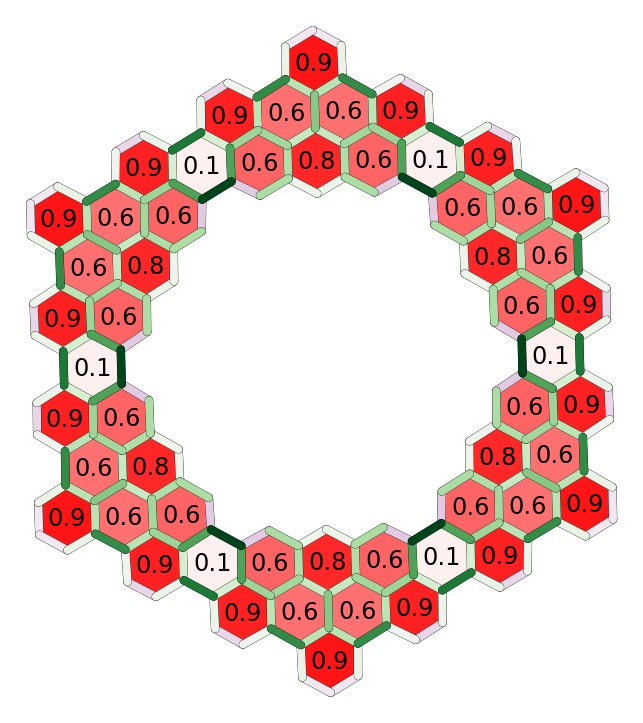

In [17]:
fig_x = (x_max - x_min + 2.0)/2.5
fig_y = (y_max - y_min + 2.0)/2.5

font = font_manager.FontProperties(fname="./arial.ttf")

plt.figure(figsize=(fig_x, fig_y))
ax = plt.gca()
ax.set_aspect('equal')

# -------------------------------------------------------------------
# ATOMS
#for at in ase_atoms_no_h:
#    pos = at.position
#    circ = plt.Circle(pos[:2], 0.08, color='black', zorder=10)
#    ax.add_artist(circ)
# -------------------------------------------------------------------
    
# -------------------------------------------------------------------
# BONDS

#b_cmap_name = 'seismic_r'
#b_cmap_name = 'bwr_r'
b_cmap_name = 'PuOr'
b_cmap_name = 'PRGn'
b_cmap = matplotlib.cm.get_cmap(b_cmap_name)

# color the bonds accordingly:
for bond, bond_dist in zip(bonds, bond_dists):
    
    p1 = ase_atoms_no_h[bond[0]].position
    p2 = ase_atoms_no_h[bond[1]].position
    
    dist_norm = (bond_dist - b_cmap_min) / (b_cmap_max - b_cmap_min)
    rgb = b_cmap(dist_norm)[:-1]
    
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='k', linewidth=8.5, solid_capstyle='round')
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color=rgb, linewidth=8.0, solid_capstyle='round')
# -------------------------------------------------------------------
    
# -------------------------------------------------------------------
# HOMAS


#h_cmap_name = 'seismic'
h_cmap_name = 'Reds'
#h_cmap_name = 'bwr'
h_cmap = matplotlib.cm.get_cmap(h_cmap_name)

cm = LinearSegmentedColormap.from_list("my_cmap_w2r", ['w', 'r'], N=100)
h_cmap = cm

h_cmap_min = 0.0
h_cmap_max = 1.0

for homa_val, cyc in zip(cycle_homas, cycs):
    
    val_norm = (homa_val - h_cmap_min) / (h_cmap_max - h_cmap_min)
    rgba = h_cmap(val_norm)
    
    points = []
    for i_at in cyc:
        points.append(ase_atoms_no_h[i_at].position[:2])
        
    polygon = Polygon(np.array(points), True, color=rgba, zorder=1)
    ax.add_artist(polygon)
    
plt.axis('off')
plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.savefig("./fig/%s_homa.png" % label, dpi=400, bbox_inches='tight', transparent=True)
plt.savefig("./fig/%s_homa.pdf" % label, bbox_inches='tight')
    
for homa_val, cntr in zip(cycle_homas, centers):
    
    #circ = Circle((cntr[0], cntr[1]), radius=0.02, color='black', zorder=1)
    #ax.add_artist(circ)
    
    font_h = 0.25
    font_h = 0.35
    
    txt = plt.text(cntr[0], cntr[1]-font_h, "%.1f" % homa_val, horizontalalignment='center',
                   verticalalignment='baseline', color='black',
                   fontdict={'size': 24})
# -------------------------------------------------------------------

plt.savefig("./fig/%s_homa_txt.png" % label, dpi=400, bbox_inches='tight', transparent=True)
plt.savefig("./fig/%s_homa_txt.pdf" % label, bbox_inches='tight')
plt.show()

# colorbars

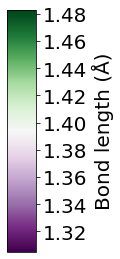

In [18]:
a = np.array([[b_cmap_min,b_cmap_max]])
plt.figure(figsize=(0.5, 5.6))
img = plt.imshow(a, cmap=b_cmap_name)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="vertical", cax=cax)
cbar.set_label(r"Bond length (Å)", fontsize=20)
cbar.ax.tick_params(labelsize=20)
cbar.set_ticks(np.arange(np.floor(b_cmap_min), np.ceil(b_cmap_max), 0.02))


plt.savefig("./fig/%s_bond_colorbar.png" % label, dpi=300, bbox_inches='tight')
plt.show()

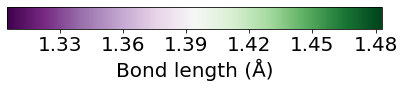

In [19]:
a = np.array([[b_cmap_min,b_cmap_max]])
plt.figure(figsize=(6.5, 0.5))
img = plt.imshow(a, cmap=b_cmap_name)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax)
cbar.set_label(r"Bond length (Å)", fontsize=20)
cbar.ax.tick_params(labelsize=20)
cbar.set_ticks(np.arange(np.floor(b_cmap_min), np.ceil(b_cmap_max), 0.03))


plt.savefig("./fig/%s_bond_colorbar_h.png" % label, dpi=300, bbox_inches='tight')
plt.show()

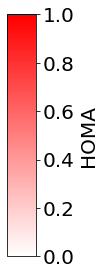

In [20]:
a = np.array([[h_cmap_min,h_cmap_max]])
plt.figure(figsize=(0.5, 5.6))
img = plt.imshow(a, cmap=h_cmap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="vertical", cax=cax)
cbar.set_label("HOMA", fontsize=20)
cbar.ax.tick_params(labelsize=20)
#cbar.set_ticks(np.arange(np.floor(b_cmap_min), np.ceil(b_cmap_max), 0.02))

plt.savefig("./fig/%s_homa_colorbar.png" % label, dpi=300, bbox_inches='tight')
plt.show()

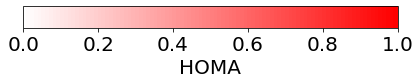

In [21]:
a = np.array([[h_cmap_min,h_cmap_max]])
plt.figure(figsize=(6.5, 0.5))
img = plt.imshow(a, cmap=h_cmap)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
cbar = plt.colorbar(orientation="horizontal", cax=cax)
cbar.set_label("HOMA", fontsize=20)
cbar.ax.tick_params(labelsize=20)
#cbar.set_ticks(np.arange(np.floor(b_cmap_min), np.ceil(b_cmap_max), 0.02))

plt.savefig("./fig/%s_homa_colorbar_h.png" % label, dpi=300, bbox_inches='tight')
plt.show()